In [1]:
%matplotlib notebook

In [2]:
import sys, os, time, gc, click, logging, pprint
from os.path import expanduser
from collections import defaultdict
import numpy as np
from mpi4py import MPI
import neuroh5
from neuroh5.io import append_cell_attributes, read_population_ranges, bcast_cell_attributes, \
    scatter_read_cell_attributes, read_cell_attribute_selection, NeuroH5ProjectionGen
import h5py


In [3]:
user_home = expanduser("~")
# neuron_home = '%s/bin/nrnpython/lib/python' % user_home
neuron_home = '/Users/milsteina/neuron/nrn_py3/lib/python'
# model_home = '%s/src/model' % user_home
model_home = '/Users/milsteina/PycharmProjects/'
dentate_home = '%s/dentate' % model_home
sys.path.append(neuron_home) 
sys.path.append(model_home) 

import dentate
from dentate.env import Env
from dentate import utils, stimulus, synapses
from dentate.utils import *

In [4]:
template_paths='%s/templates' % dentate_home
dataset_prefix='%s/datasets' % dentate_home
config_prefix='%s/config' % dentate_home


In [5]:
destination = 'GC'
sources = ['MPP', 'LPP']
const_sources = ['MC']  # []
synapse_name='AMPA'
config_file='Network_Clamp_GC_Exc_Sat_SLN_extent.yaml'
output_weights_namespace='Structured Weights'
h5types_path='%s/dentate_h5types.h5' % dataset_prefix
# connections_path='%s/Slice/dentatenet_Full_Scale_GC_Exc_Sat_DD_SLN_extent_20200606.h5' % dataset_prefix
connections_path='%s/Slice/dentatenet_Full_Scale_GC_Exc_Sat_DD_S_extent_20200606.h5' % dataset_prefix
input_features_path="%s/Full_Scale_Control/DG_input_features_20200611_compressed.h5" % dataset_prefix
initial_weights_namespace="Log-Normal Weights"  # None  # 
# initial_weights_path='%s/Slice/dentatenet_Full_Scale_GC_Exc_Sat_DD_SLN_extent_20200606.h5' % dataset_prefix
initial_weights_path='%s/Slice/dentatenet_Full_Scale_GC_Exc_Sat_DD_S_extent_20200606.h5' % dataset_prefix

arena_id='A' 
use_arena_margin=True
coordinates=(0.0, 0.0) 
optimize_tol=1e-3
optimize_grad=True
max_delta_weight=8
gid=47123
field_width_scale = 1.25
target_amplitude=3.0
initial_weight_decay_fraction=1.

In [6]:
np.seterr(all='raise')
os.chdir(dentate_home)
env = Env(config_prefix=config_prefix,config_file=config_file,template_paths=template_paths,dataset_prefix=dataset_prefix)


In [7]:
input_features_namespaces = ['Place Selectivity', 'Grid Selectivity']
this_input_features_namespaces = ['%s %s' % (input_features_namespace, arena_id) 
                                  for input_features_namespace in input_features_namespaces]

selectivity_type_index = { i: n for n, i in viewitems(env.selectivity_types) }
target_selectivity_type_name = 'place'
target_selectivity_type = env.selectivity_types[target_selectivity_type_name]
features_attrs = defaultdict(dict)
source_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate',
                                  'Module ID', 'Grid Spacing', 'Grid Orientation', 'Field Width Concentration Factor', 
                                  'X Offset', 'Y Offset']
target_features_attr_names = ['Selectivity Type', 'Num Fields', 'Field Width', 'Peak Rate', 
                                  'X Offset', 'Y Offset']

local_random = np.random.RandomState()

seed_offset = int(env.model_config['Random Seeds']['GC Structured Weights'])
spatial_resolution = env.stimulus_config['Spatial Resolution'] # cm

arena = env.stimulus_config['Arena'][arena_id]
default_run_vel = arena.properties['default run velocity']  # cm/s

gid_count = 0
target_gid_set = set([gid])
all_sources = sources + const_sources
 

In [8]:
spatial_resolution

1.0

In [9]:
connection_gen_list = [ NeuroH5ProjectionGen(connections_path, source, destination, namespaces=['Synapses']) 
                        for source in all_sources ]
field_width = None
peak_rate = None
structured_weights_dict = {}

for iter_count, attr_gen_package in enumerate(zip_longest(*connection_gen_list)):
        
        this_gid = attr_gen_package[0][0]
        if not all([attr_gen_items[0] == this_gid for attr_gen_items in attr_gen_package]):
            raise Exception('destination: %s; this_gid not matched across multiple attribute '
                            'generators: %s' % (destination,
                                                [attr_gen_items[0] for attr_gen_items in attr_gen_package]))

        if (target_gid_set is not None) and (this_gid not in target_gid_set):
            continue


        if this_gid is None:
            selection = []
            logger.info('received None')
        else:
            selection = [this_gid]
            local_random.seed(int(this_gid + seed_offset))

        has_structured_weights = False

        dst_input_features_attr_dict = {}
        for input_features_namespace in this_input_features_namespaces:
            print(input_features_namespace, destination, selection)
            input_features_iter = read_cell_attribute_selection(input_features_path, destination, 
                                                                namespace=input_features_namespace,
                                                                mask=set(target_features_attr_names), 
                                                                selection=selection)
            count = 0
            for gid, attr_dict in input_features_iter:
                dst_input_features_attr_dict[gid] = attr_dict
                count += 1
            logger.info('Read %s feature data for %i cells in population %s' % (input_features_namespace, count, destination))

        arena_margin = 0.
        target_selectivity_features_dict = {}
        target_selectivity_config_dict = {}
        target_field_width_dict = {}
        for gid in selection:
            target_selectivity_features_dict[gid] = dst_input_features_attr_dict.get(gid, {})
            target_selectivity_features_dict[gid]['Selectivity Type'] = np.asarray([target_selectivity_type], dtype=np.uint8)

            num_fields = target_selectivity_features_dict[gid]['Num Fields'][0]
            
            if coordinates[0] is not None:
                num_fields = 1
                target_selectivity_features_dict[gid]['X Offset'] =  np.asarray([coordinates[0]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Y Offset'] =  np.asarray([coordinates[1]], dtype=np.float32)
                target_selectivity_features_dict[gid]['Num Fields'] = np.asarray([num_fields], dtype=np.uint8)

            if field_width is not None:
                target_selectivity_features_dict[gid]['Field Width'] = np.asarray([field_width]*num_fields, dtype=np.float32)
            else:
                this_field_width = target_selectivity_features_dict[gid]['Field Width']
                target_selectivity_features_dict[gid]['Field Width'] = this_field_width[:num_fields]
                
            if peak_rate is not None:
                target_selectivity_features_dict[gid]['Peak Rate'] = np.asarray([peak_rate]*num_fields, dtype=np.float32)

            input_cell_config = stimulus.get_input_cell_config(target_selectivity_type,
                                                               selectivity_type_index,
                                                               selectivity_attr_dict=target_selectivity_features_dict[gid])
            if input_cell_config.num_fields > 0:
                arena_margin = max(arena_margin, np.max(input_cell_config.field_width) / 2.) if use_arena_margin else 0.
                target_field_width_dict[gid] = input_cell_config.field_width
                target_selectivity_config_dict[gid] = input_cell_config
                has_structured_weights = True

        arena_x, arena_y = stimulus.get_2D_arena_spatial_mesh(arena, spatial_resolution,
                                                              margin=arena_margin)
        for gid, input_cell_config in viewitems(target_selectivity_config_dict):
            target_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y,
                                                                   scale=field_width_scale),
                                    dtype=np.float32)
            target_selectivity_features_dict[gid]['Arena Rate Map'] = target_map

                
        if not has_structured_weights:
            selection = []
                
        initial_weights_by_syn_id_dict = defaultdict(lambda: dict())
        initial_weights_by_source_gid_dict = defaultdict(lambda: dict())
        if initial_weights_path is not None:
            initial_weights_iter = \
              read_cell_attribute_selection(initial_weights_path, destination,
                                            namespace=initial_weights_namespace,
                                            selection=selection)

            initial_weights_gid_count = 0
            for this_gid, syn_weight_attr_dict in initial_weights_iter:
                syn_ids = syn_weight_attr_dict['syn_id']
                weights = syn_weight_attr_dict[synapse_name]

                for (syn_id, weight) in zip(syn_ids, weights):
                    initial_weights_by_syn_id_dict[this_gid][int(syn_id)] = float(weight)
                initial_weights_gid_count += 1

            logger.info('destination: %s; read initial synaptic weights for %i gids' %
                        (destination, initial_weights_gid_count))
            
             

        syn_count_by_source_gid_dict = defaultdict(int)
        source_gid_set_dict = defaultdict(set)
        syn_ids_by_source_gid_dict = defaultdict(list)
        structured_syn_id_count = 0

        if has_structured_weights:
            for source, (destination_gid, (source_gid_array, conn_attr_dict)) in zip_longest(all_sources, attr_gen_package):
                syn_ids = conn_attr_dict['Synapses']['syn_id']
                count = 0
                this_initial_weights_by_syn_id_dict = None
                this_initial_weights_by_source_gid_dict = None
                
                if destination_gid is not None:
                    this_initial_weights_by_syn_id_dict = initial_weights_by_syn_id_dict[destination_gid]
                    this_initial_weights_by_source_gid_dict = initial_weights_by_source_gid_dict[destination_gid]
                    

                for i in range(len(source_gid_array)):
                    this_source_gid = source_gid_array[i]
                    this_syn_id = syn_ids[i]
                    this_syn_wgt = this_initial_weights_by_syn_id_dict.get(this_syn_id, 1.0)
                    source_gid_set_dict[source].add(this_source_gid)
                    syn_ids_by_source_gid_dict[this_source_gid].append(this_syn_id)
                    syn_count_by_source_gid_dict[this_source_gid] += 1
                    if this_source_gid not in this_initial_weights_by_source_gid_dict:
                        this_initial_weights_by_source_gid_dict[this_source_gid] = this_syn_wgt
                    
                    count += 1
                if source not in const_sources:
                    structured_syn_id_count += len(syn_ids)
                logger.info('destination: %s; gid %i; %d edges from source population %s' %
                            (destination, this_gid, count, source))


        input_rate_maps_by_source_gid_dict = {}
        if len(const_sources) > 0:
            const_input_rate_maps_by_source_gid_dict = {}
        else:
            const_input_rate_maps_by_source_gid_dict = None
        for source in all_sources:
            if has_structured_weights:
                source_gids = list(source_gid_set_dict[source])
            else:
                source_gids = []
            logger.info('Reading %s feature data for %i cells in population %s...' % (input_features_namespace, len(source_gids), source))
            for input_features_namespace in this_input_features_namespaces:
                input_features_iter = read_cell_attribute_selection(input_features_path, source, 
                                                                    namespace=input_features_namespace,
                                                                    mask=set(source_features_attr_names), 
                                                                    comm=env.comm, selection=source_gids)
                count = 0
                for gid, attr_dict in input_features_iter:
                    this_selectivity_type = attr_dict['Selectivity Type'][0]
                    this_selectivity_type_name = selectivity_type_index[this_selectivity_type]
                    input_cell_config = stimulus.get_input_cell_config(this_selectivity_type,
                                                                       selectivity_type_index,
                                                                       selectivity_attr_dict=attr_dict)
                    this_arena_rate_map = np.asarray(input_cell_config.get_rate_map(arena_x, arena_y),
                                                     dtype=np.float32)
                    if source in const_sources:
                        const_input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    else:
                        input_rate_maps_by_source_gid_dict[gid] = this_arena_rate_map
                    count += 1
                
                logger.info('Read %s feature data for %i cells in population %s' % (input_features_namespace, count, source))

        if has_structured_weights:

            structured_weights_dict[gid] = \
                {'target_map': target_selectivity_features_dict[this_gid]['Arena Rate Map'],
                 'initial_weight_dict': this_initial_weights_by_source_gid_dict,
                 'input_rate_map_dict': input_rate_maps_by_source_gid_dict,
                 'const_input_rate_map_dict': const_input_rate_maps_by_source_gid_dict,
                 'syn_count_dict': syn_count_by_source_gid_dict,
                 'max_delta_weight': max_delta_weight, 
                 'arena_x': arena_x, 
                 'arena_y': arena_y
                }



Place Selectivity A GC [47123]
Grid Selectivity A GC [47123]


In [10]:
target_map = structured_weights_dict[gid]['target_map']
initial_weight_dict = structured_weights_dict[gid]['initial_weight_dict']
input_rate_map_dict = structured_weights_dict[gid]['input_rate_map_dict']
const_input_rate_map_dict = structured_weights_dict[gid]['const_input_rate_map_dict']
syn_count_dict = structured_weights_dict[gid]['syn_count_dict']
arena_x = structured_weights_dict[gid]['arena_x']
arena_y = structured_weights_dict[gid]['arena_y']

input_matrix = np.empty((target_map.size, len(input_rate_map_dict)),
                            dtype=np.float64)
source_gid_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
syn_count_array = np.empty(len(input_rate_map_dict), dtype=np.uint32)
initial_weight_array = np.empty(len(input_rate_map_dict), dtype=np.float64)
for i, source_gid in enumerate(input_rate_map_dict):
    source_gid_array[i] = source_gid
    this_syn_count = syn_count_dict[source_gid]
    this_input = input_rate_map_dict[source_gid].ravel() * this_syn_count
    input_matrix[:, i] = this_input
    syn_count_array[i] = this_syn_count
    initial_weight_array[i] = initial_weight_dict[source_gid]


const_input_matrix = None
if const_input_rate_map_dict is not None:
   const_input_matrix = np.empty((target_map.size, len(const_input_rate_map_dict)),
                                 dtype=np.float64)
   const_weight_array = np.empty(len(const_input_rate_map_dict), dtype=np.float64)
   for i, source_gid in enumerate(const_input_rate_map_dict):
        this_syn_count = syn_count_dict[source_gid]
        this_input = const_input_rate_map_dict[source_gid].ravel() * this_syn_count
        const_input_matrix[:, i] = this_input
        const_weight_array[i] = 1.
            


<IPython.core.display.Javascript object>


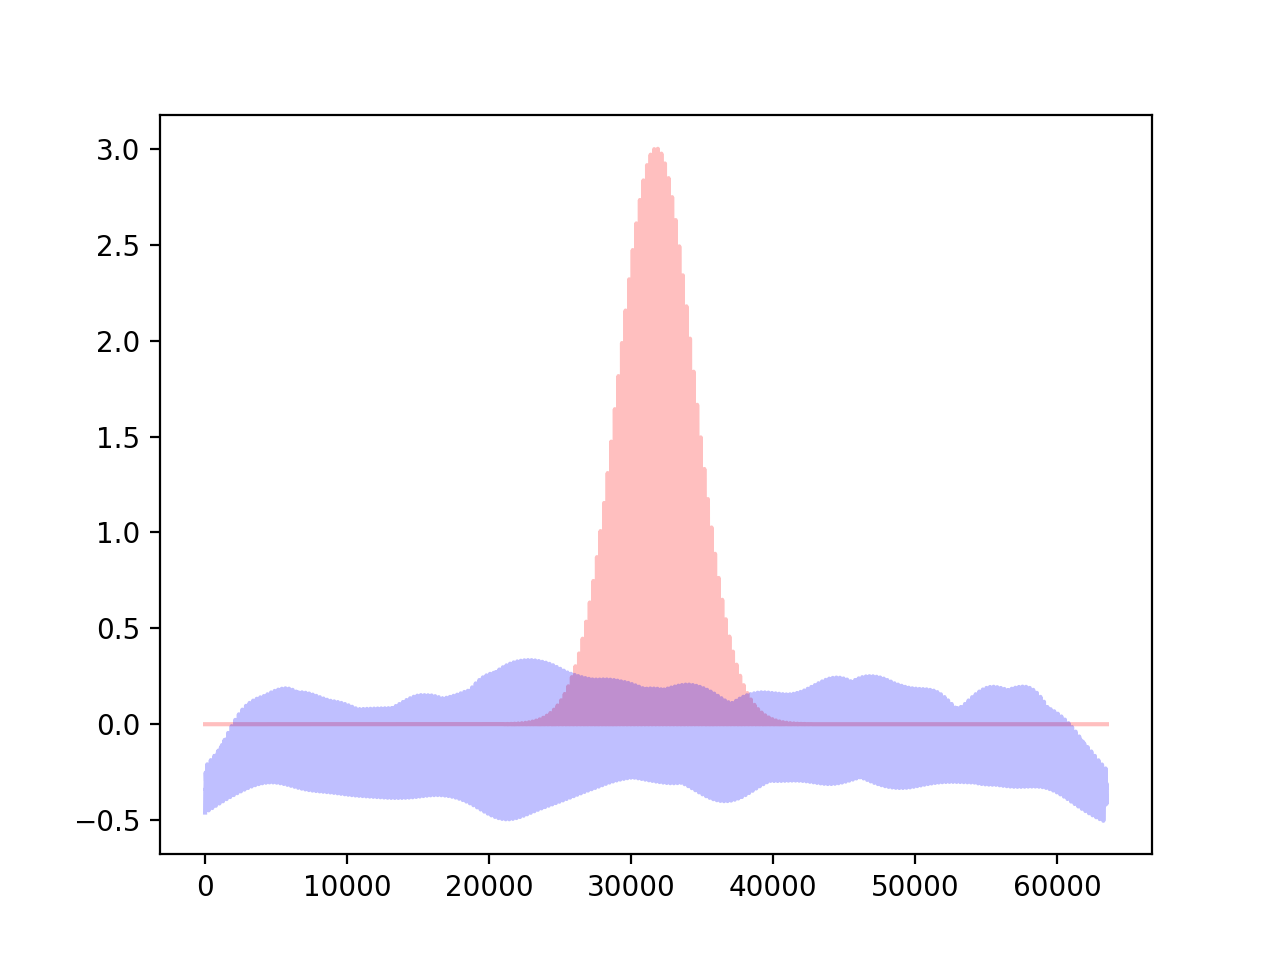

In [38]:
import matplotlib.pyplot as plt

mean_initial_weight = np.mean(initial_weight_array)
initial_background_map = np.dot(input_matrix, initial_weight_array) + \
                         np.dot(const_input_matrix, const_weight_array)
if np.mean(initial_background_map)<= 0.:
   raise RuntimeError('generate_structured_delta_weights: initial weights must produce positive activation')

mean_initial_background = np.mean(initial_background_map)
scaled_background_map = initial_background_map / mean_initial_background
scaled_background_map -= 1.
# I don't think the min of target_map should be subtracted here. If a target map has nonzero background, we need
# structured weights to provide that (e.g. very wide fields or multiple fields)
# scaled_target_map = np.asarray(target_map.flat - np.min(target_map), dtype=np.float64)
scaled_target_map = np.asarray(target_map.flat, dtype=np.float64)


if np.max(scaled_target_map) > 0.:
   target_map_scaling_factor = target_amplitude / np.max(target_map)
   scaled_target_map = scaled_target_map.flat * target_map_scaling_factor
flat_scaled_target_map = scaled_target_map.ravel()


plt.figure()
plt.plot(flat_scaled_target_map, c='r', alpha=0.25)
plt.plot(scaled_background_map, c='b', alpha=0.25)
# The activity of the inputs is designed to be uniform inside the arena. By adding an additional arena margin,
# you are revealing a decrease in mean input activity at the margins. Perhaps the mean could be calculated only
# within arena.

<IPython.core.display.Javascript object>


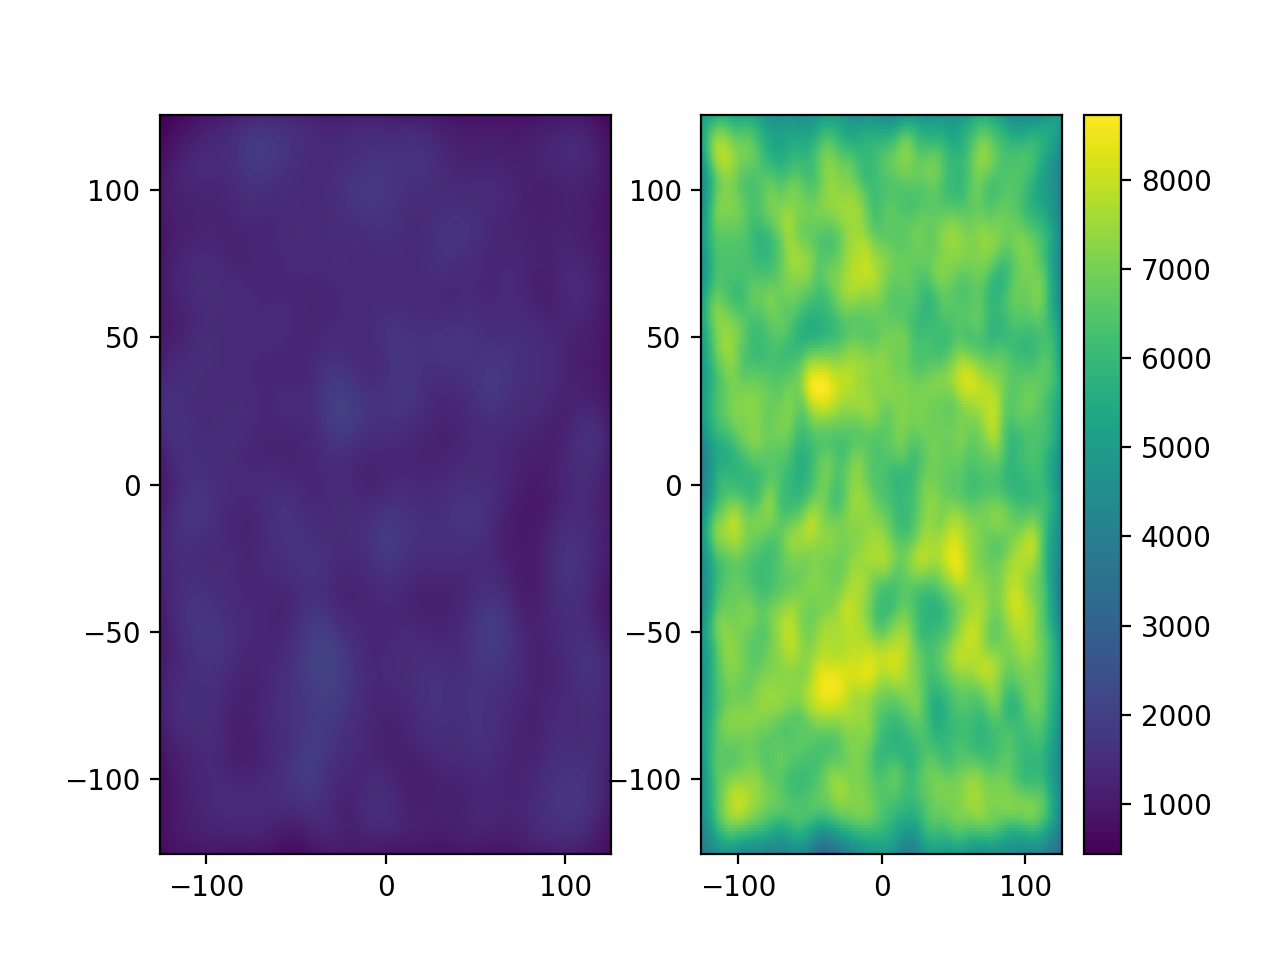

In [39]:
fig, axes = plt.subplots(1, 2)
non_structured_background = np.dot(const_input_matrix, const_weight_array)
structured_background = np.dot(input_matrix, initial_weight_array)
activity_min = min(np.min(non_structured_background), np.min(structured_background))
activity_max = max(np.max(non_structured_background), np.max(structured_background))
axes[0].pcolormesh(arena_x, arena_y, non_structured_background.reshape(arena_x.shape), vmin=activity_min, vmax=activity_max)
pcm = axes[1].pcolormesh(arena_x, arena_y, structured_background.reshape(arena_x.shape), vmin=activity_min, vmax=activity_max)
fig.colorbar(pcm, ax=axes[1])

<IPython.core.display.Javascript object>


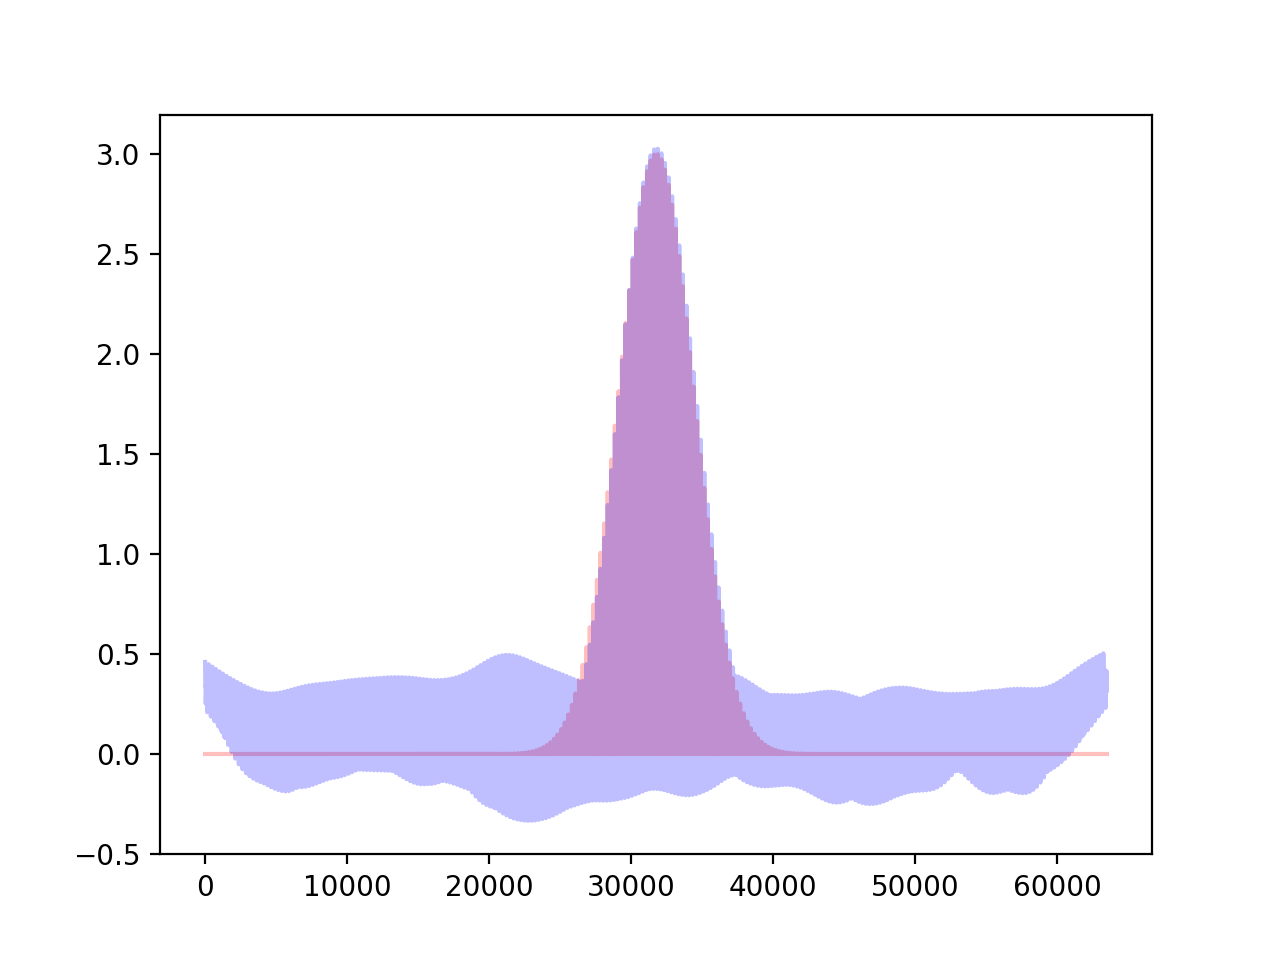

In [40]:
# the background_map should not be subtracted from the target_map here
# lsqr_target_map = np.copy(scaled_target_map) - scaled_background_map
bad_lsqr_target_map = np.copy(scaled_target_map) - scaled_background_map
lsqr_target_map = np.copy(scaled_target_map)

plt.figure()
plt.plot(lsqr_target_map, c='r', alpha=0.25)
plt.plot(bad_lsqr_target_map, c='b', alpha=0.25)

In [25]:
res = scipy.sparse.linalg.lsmr(scaled_input_matrix,
                               lsqr_target_map,
                               atol=optimize_tol, btol=optimize_tol,
                               damp=0.1, show=True)
lsqr_delta_weights = np.asarray(res[0], dtype=np.float32)    


 
LSMR            Least-squares solution of  Ax = b

The matrix A has    63504 rows  and     2011 cols
damp = 1.00000000000000e-01

atol = 1.00e-03                 conlim = 1.00e+08

btol = 1.00e-03             maxiter =     2011

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  5.609e+01  8.998e+01   1.0e+00  2.9e-02
     1  0.00000e+00  5.422e+01  6.360e+01   9.7e-01  2.2e-01  5.4e+00  1.0e+00
     2  0.00000e+00  3.343e+01  2.993e+01   6.0e-01  1.1e-01  8.0e+00  5.2e+00
     3  0.00000e+00  2.683e+01  1.995e+01   4.8e-01  9.1e-02  8.2e+00  5.1e+00
     4  0.00000e+00  2.182e+01  1.294e+01   3.9e-01  7.0e-02  8.5e+00  5.4e+00
     5  0.00000e+00  1.858e+01  9.106e+00   3.3e-01  5.6e-02  8.7e+00  6.5e+00
     6  0.00000e+00  1.615e+01  6.671e+00   2.9e-01  4.6e-02  8.9e+00  7.3e+00
     7  0.00000e+00  1.459e+01  4.967e+00   2.6e-01  3.7e-02  9.1e+00  6.9e+00
     8  0.00000e+00  1.352e+01  3.920e+00   2.4e-01  3.1e-02  9.3e+00  8.1

<IPython.core.display.Javascript object>


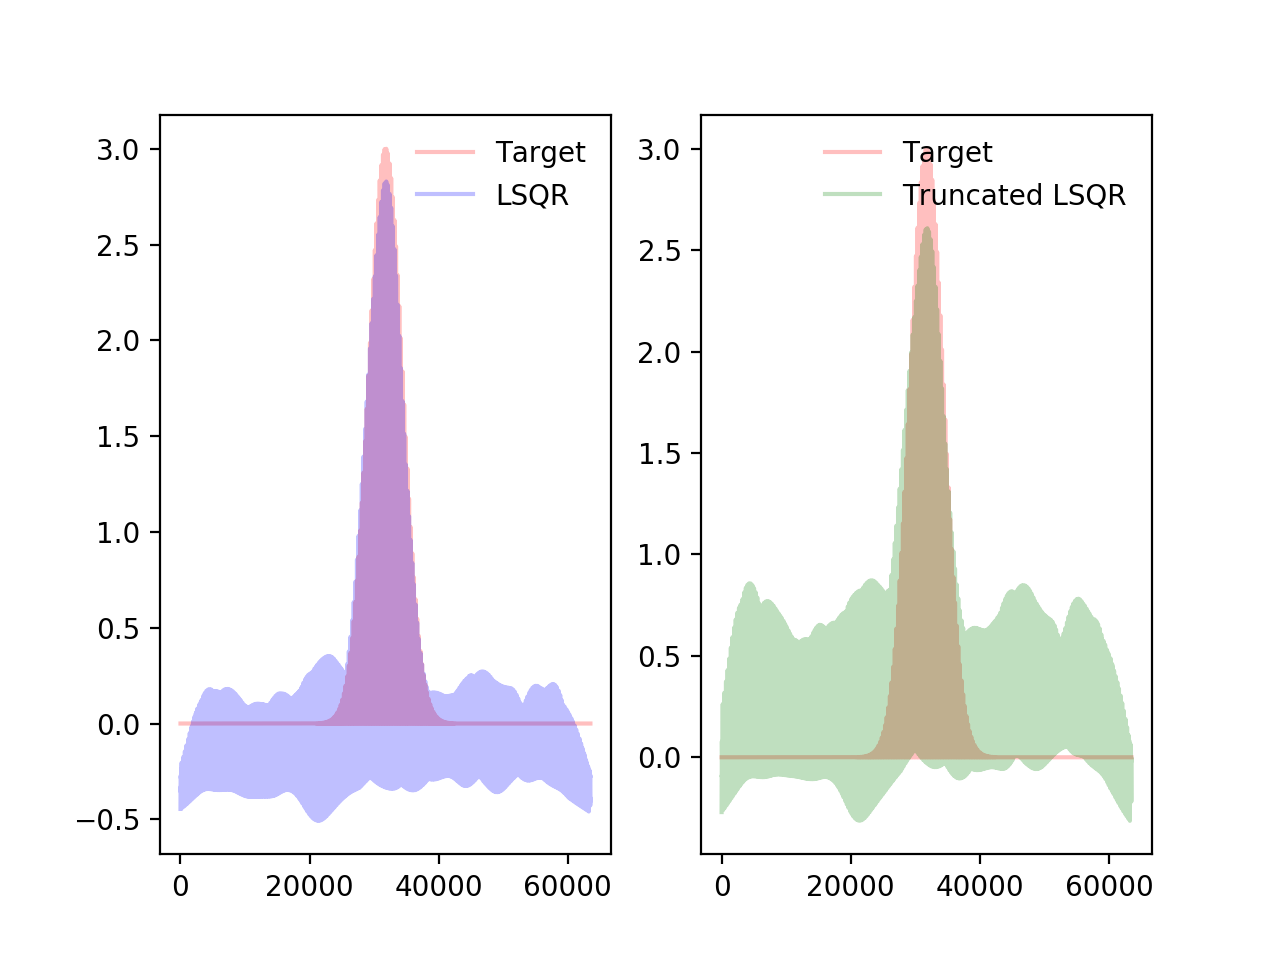

<IPython.core.display.Javascript object>


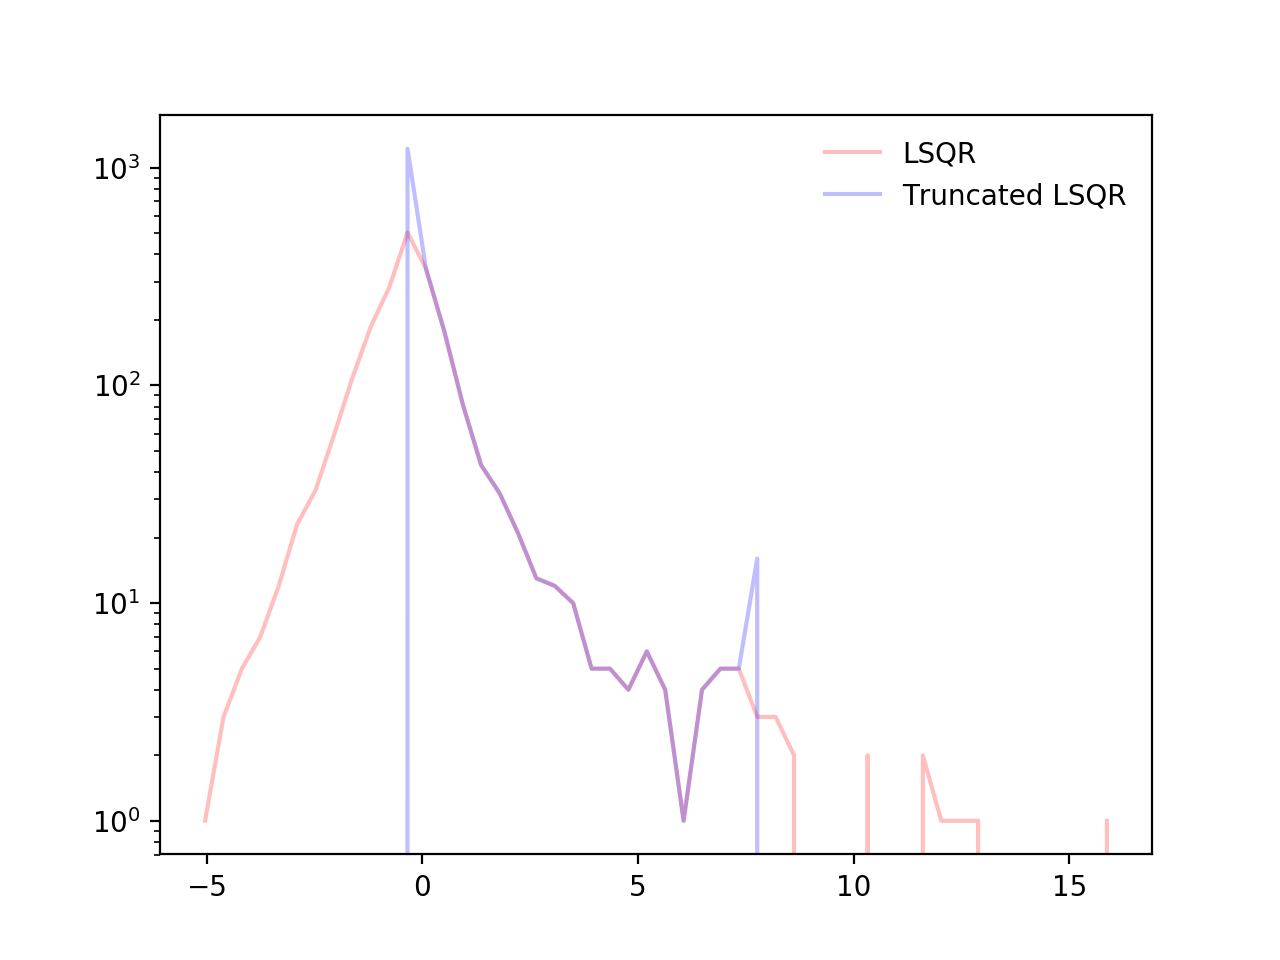

In [73]:
max_weight = 4.0
assert(max_weight >= 1.)
initial_weight_decay_fraction = 1.0
initial_min = np.min(initial_weight_array)

# The bounds on delta_weights are (0., max_delta_weight)
# lb = -(initial_weight_decay_fraction * initial_min)
# ub = max_weight - np.max(initial_weight_array)
lb = 0.
ub = max_delta_weight
initial_LS_bounds = (lb, ub)
initial_LS_delta_weights = np.clip(lsqr_delta_weights, initial_LS_bounds[0], initial_LS_bounds[1])

lsqr_map = np.dot(scaled_input_matrix, lsqr_delta_weights + initial_weight_array) - 1
if scaled_const_input_matrix is not None:
    lsqr_map += np.dot(scaled_const_input_matrix, const_weight_array)
initial_LS_map = np.dot(scaled_input_matrix, initial_LS_delta_weights + initial_weight_array) - 1
if scaled_const_input_matrix is not None:
    initial_LS_map += np.dot(scaled_const_input_matrix, const_weight_array)

fig, axes = plt.subplots(1, 2)
axes[0].plot(lsqr_target_map, c='r', alpha=0.25, label='Target')
axes[1].plot(lsqr_target_map, c='r', alpha=0.25, label='Target')
axes[0].plot(lsqr_map, c='b', alpha=0.25, label='LSQR')
axes[1].plot(initial_LS_map, c='g', alpha=0.25, label='Truncated LSQR')
axes[0].legend(loc='best', frameon=False, framealpha=0.5)
axes[1].legend(loc='best', frameon=False, framealpha=0.5)

plt.figure()
hist, edges = np.histogram(lsqr_delta_weights, bins=50)
plt.semilogy(edges[:-1], hist, color='r', alpha=0.25, label='LSQR')
hist, edges = np.histogram(initial_LS_delta_weights, bins=edges)
plt.semilogy(edges[:-1], hist, color='b', alpha=0.25, label='Truncated LSQR')
plt.legend(loc='best', frameon=False, framealpha=0.5)


In [45]:
def activation_map_residual(delta_weights, input_matrix, target_map, background_map):
    a = np.dot(input_matrix, delta_weights)
    e = np.subtract(target_map, a + background_map)
                                           
    res = np.square(e).mean() / 2.
    return np.asarray(res, dtype=np.float64)

def activation_map_residual_grad(weights, input_matrix, target_map, background_map):
    N = weights.shape[0]
    a = np.dot(input_matrix, weights)
    e = np.subtract(target_map, a + background_map)
    grad = -1./N * np.dot(input_matrix.T, e)
    return np.asarray(grad, dtype=np.float64)


In [47]:
initial_LS_bounds

(0.0, 8)

In [46]:
import scipy.optimize as opt
optimize_method = 'L-BFGS-B'

method_options = {'disp': True, 'maxiter': 1000}
method_options['maxfun'] = 1000000

result = opt.minimize(activation_map_residual,
                      initial_LS_delta_weights, 
                      jac=activation_map_residual_grad if optimize_grad else None,
                      args=(scaled_input_matrix, lsqr_target_map.flat, scaled_background_map.flat),
                      method=optimize_method,
                      bounds=[initial_LS_bounds for x in initial_weight_array],
                      tol=optimize_tol,
                      options=method_options)
LS_delta_weights = np.array(result.x)


0.0
8.0
0.1936934875353928
0.8882922626886514
max_delta_weight would have to increase to 16.3 to reach target_amplitude


<IPython.core.display.Javascript object>


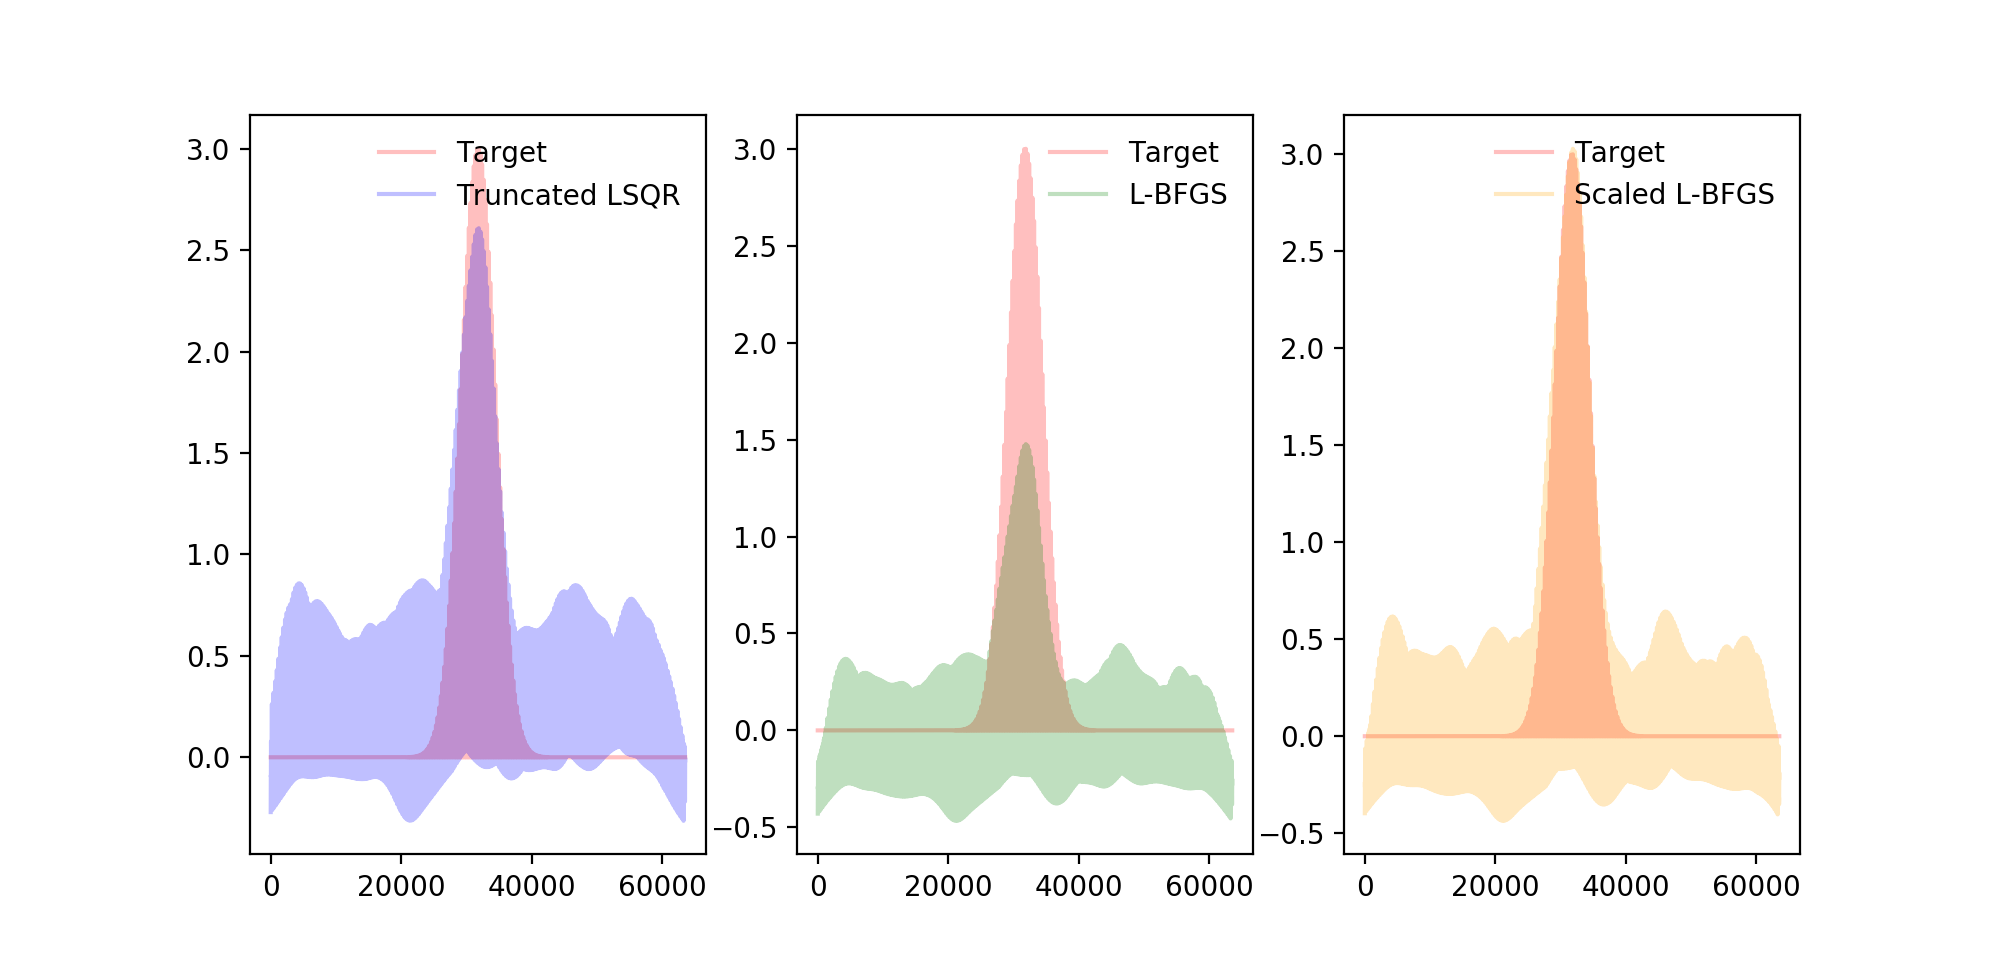

<IPython.core.display.Javascript object>


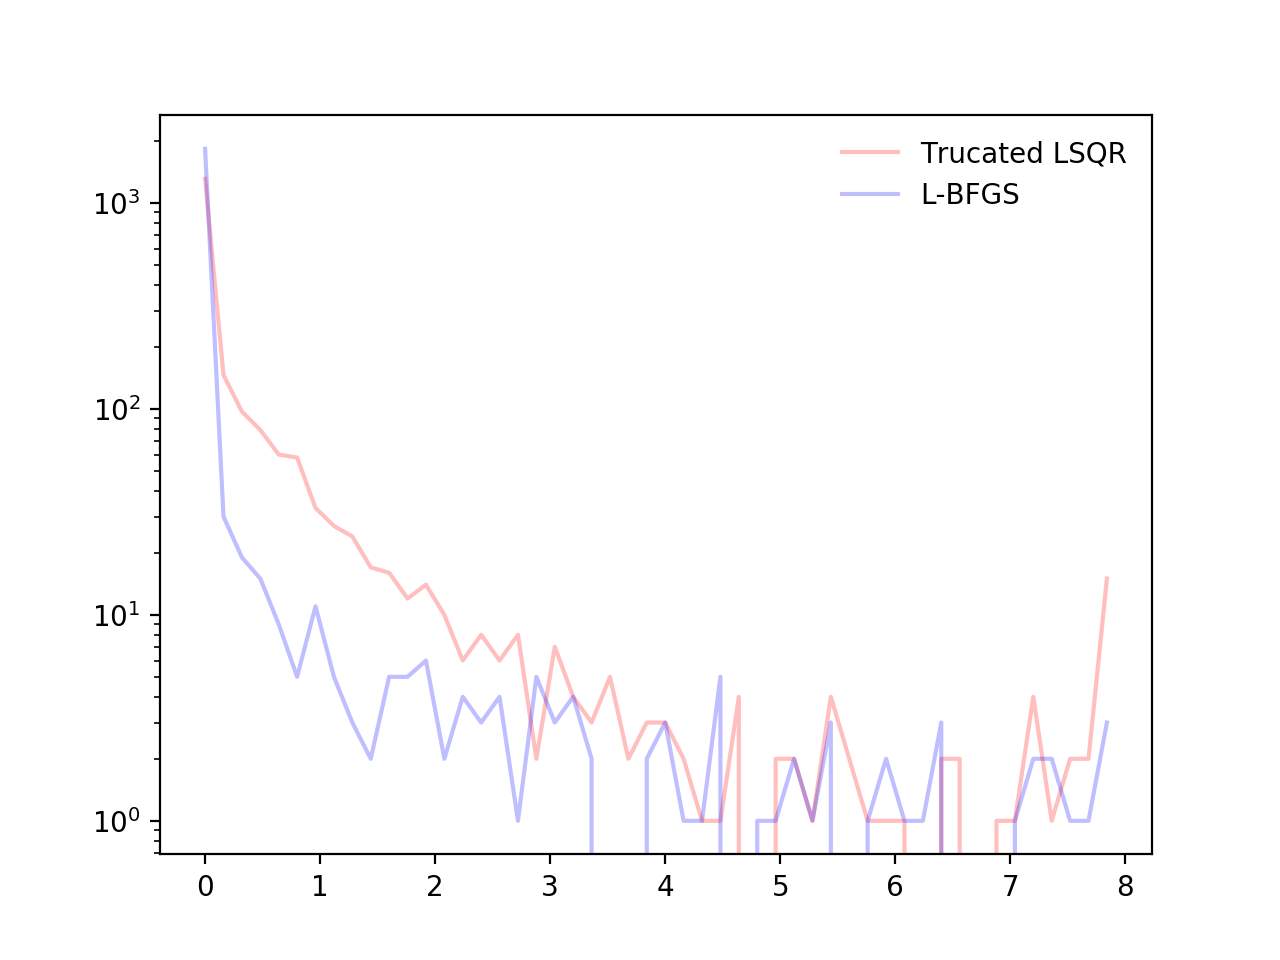

In [72]:
print(np.min(LS_delta_weights))
print(np.max(LS_delta_weights))
print(np.mean(LS_delta_weights))
print(np.std(LS_delta_weights))

LS_delta_map = np.dot(scaled_input_matrix, LS_delta_weights + initial_weight_array) - 1

if scaled_const_input_matrix is not None:
    LS_delta_map += np.dot(scaled_const_input_matrix, const_weight_array)

normalized_delta_weights_array = LS_delta_weights / np.max(LS_delta_weights)
scaled_LS_delta_weights = LS_delta_weights * target_amplitude / np.max(LS_delta_map)
    
scaled_LS_delta_map = np.dot(scaled_input_matrix, scaled_LS_delta_weights + initial_weight_array) - 1
if scaled_const_input_matrix is not None:
    scaled_LS_delta_map += np.dot(scaled_const_input_matrix, const_weight_array)
print('max_delta_weight would have to increase to %.1f to reach target_amplitude' % (np.max(scaled_LS_delta_weights))) 

fig, axes = plt.subplots(1, 3, figsize=(10., 4.8))
axes[0].plot(lsqr_target_map, c='r', alpha=0.25, label='Target')
axes[1].plot(lsqr_target_map, c='r', alpha=0.25, label='Target')
axes[2].plot(lsqr_target_map, c='r', alpha=0.25, label='Target')
axes[0].plot(initial_LS_map, c='b', alpha=0.25, label="Truncated LSQR")
axes[1].plot(LS_delta_map, c='g', alpha=0.25, label="L-BFGS")
axes[2].plot(scaled_LS_delta_map, c='orange', alpha=0.25, label="Scaled L-BFGS")
axes[0].legend(loc='best', frameon=False, framealpha=0.5)
axes[1].legend(loc='best', frameon=False, framealpha=0.5)
axes[2].legend(loc='best', frameon=False, framealpha=0.5)

plt.figure()
hist, edges = np.histogram(initial_LS_delta_weights, bins=50)
plt.semilogy(edges[:-1], hist, color='r', alpha=0.25, label='Trucated LSQR')
hist, edges = np.histogram(LS_delta_weights, bins=edges)
plt.semilogy(edges[:-1], hist, color='b', alpha=0.25, label='L-BFGS')
plt.legend(loc='best', frameon=False, framealpha=0.5)